### File Explanation

**trainRNN_StaticModel_dropout.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create a "Static Network" and train the network with respect to a range of dropout rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer static model (function: **LSTM_Model** in **trainRNN_network_utils.py**)
<br> 5) Create a single normalised output by using the last outputs of static models of gene A and gene B (function: **batch_normalised_sum** in **trainRNN_network_utils.py**)
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsStaticDropout_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.4, 0.5, 0.6, 0.7, 0.8])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData.ipynb"

# Save data into Python file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )

# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [3]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropouts = [0.4, 0.5, 0.6, 0.7, 0.8]                # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 100
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches

### Network and Train

In [4]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for dropout in dropouts:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_A = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_A, current_state_A = LSTM_Model(rSnpRnaA_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_B = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_B, current_state_B = LSTM_Model(rSnpRnaB_pXNS, 
                                                      init_state_B, 
                                                      n_layer, 
                                                      n_hidden,
                                                      dropout)

    hidden_output = batch_normalised_sum(hidden_output_A, hidden_output_B)

    ## Output placeholder
    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    # Dense Layer
    logit = tf.layers.dense( hidden_output,
                            units = n_classes, 
                            activation = None,
                            kernel_initializer = tf.initializers.random_normal() ) 

    prediction = tf.nn.softmax( logit )

    ## Loss and optimiser
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)))

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            # Initial current_state
            _current_state_A = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_B = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_tst_A = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))
            _current_state_tst_B = np.zeros((n_layer, 2, rSnpB_tst_nXSN.shape[0], n_hidden))

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC,
                        init_state_A: _current_state_A,                      
                        init_state_B: _current_state_B,                       
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC,
                        init_state_A: _current_state_tst_A,                      
                        init_state_B: _current_state_tst_B,
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            
        trainLosses[dropout] = train_losses
        testLosses[dropout] = test_losses
        trainAccuracy[dropout] = train_accuracies
        F1_scores[dropout] = test_f1_score
        print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.0735054016113281: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.2089922428131104: Accuracy = 0.19

Performance on training data: Loss = 0.9120000600814819: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1804972887039185: Accuracy = 0.5310196756928458

Data shuffled. Epoch:  28
Performance on training data: Loss = 0.9005811214447021: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.104692816734314: Accuracy = 0.5402993171523224

Data shuffled. Epoch:  29
Performance on training data: Loss = 0.9086049795150757: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1114764213562012: Accuracy = 0.5478808198360272

Data shuffled. Epoch:  30
Performance on training data: Loss = 0.9082030653953552: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.1185803413391113: Accuracy = 0.5532620023320471

Data shuffled. Epoch:  31
Performance on training data: Loss = 0.9163889288902283: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1790589094161987: Accuracy = 0.5560754687166783

Data shuffled. Epoch:  32
Performance

Performance on training data: Loss = 0.8581061363220215: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.30025053024292: Accuracy = 0.4825685672945416

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.9314706325531006: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.2811428308486938: Accuracy = 0.4814385128193857

Data shuffled. Epoch:  71
Performance on training data: Loss = 1.0163079500198364: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.280485987663269: Accuracy = 0.4777522893525273

Data shuffled. Epoch:  72
Performance on training data: Loss = 0.956105649471283: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.2552917003631592: Accuracy = 0.4743219954420946

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.9349452257156372: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.2491343021392822: Accuracy = 0.4722319656899977

Data shuffled. Epoch:  74
Performance on

Performance on training data: Loss = 0.8791195750236511: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.3094017505645752: Accuracy = 0.47492715545099073

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.8594319820404053: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.2727421522140503: Accuracy = 0.47436082789896805

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.9333376884460449: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.2736749649047852: Accuracy = 0.4739171002120353

Data shuffled. Epoch:  114
Performance on training data: Loss = 0.8682503700256348: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.281618595123291: Accuracy = 0.473456967359654

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.867537260055542: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.2675648927688599: Accuracy = 0.4731047259556422

Data shuffled. Epoch:  116
Perfor

Performance on training data: Loss = 0.8612809181213379: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.2689017057418823: Accuracy = 0.45110029494102355

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.8500948548316956: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2868119478225708: Accuracy = 0.450551708321845

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.9186264872550964: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2770696878433228: Accuracy = 0.45009844112286124

Data shuffled. Epoch:  156
Performance on training data: Loss = 0.8505175113677979: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.3296512365341187: Accuracy = 0.4495860464613505

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8646103143692017: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2943280935287476: Accuracy = 0.44913658284192715

Data shuffled. Epoch:  158
Perf

Performance on training data: Loss = 0.8242591023445129: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.2778996229171753: Accuracy = 0.43271428500132

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.883465588092804: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.3340613842010498: Accuracy = 0.43250813297303703

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.8296279311180115: Accuracy = 0.7300000190734863
Performance on test set: : Loss = 1.29176926612854: Accuracy = 0.4328217078105326

Data shuffled. Epoch:  198
Performance on training data: Loss = 0.8617771863937378: Accuracy = 0.6899999976158142
Performance on test set: : Loss = 1.2797987461090088: Accuracy = 0.43311975530388247

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.7791932821273804: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.311916470527649: Accuracy = 0.4333969108106547

Optimisation finished!
Data shuffled

Performance on training data: Loss = 1.01307213306427: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.1584612131118774: Accuracy = 0.43188941144044757

Data shuffled. Epoch:  38
Performance on training data: Loss = 0.9584726095199585: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.2107620239257812: Accuracy = 0.4331099664008513

Data shuffled. Epoch:  39
Performance on training data: Loss = 0.9798398613929749: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.203035593032837: Accuracy = 0.43432052033436613

Data shuffled. Epoch:  40
Performance on training data: Loss = 0.969718873500824: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.161123275756836: Accuracy = 0.4358068763817292

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.9350002408027649: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1802595853805542: Accuracy = 0.4362839960066611

Data shuffled. Epoch:  42
Performance on

Performance on training data: Loss = 0.8531856536865234: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.265815258026123: Accuracy = 0.4317274445856125

Data shuffled. Epoch:  80
Performance on training data: Loss = 0.8377281427383423: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.251258134841919: Accuracy = 0.43133718583468267

Data shuffled. Epoch:  81
Performance on training data: Loss = 0.9311709403991699: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.3087728023529053: Accuracy = 0.4311169764018495

Data shuffled. Epoch:  82
Performance on training data: Loss = 0.9212796092033386: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.3126527070999146: Accuracy = 0.43041608183599966

Data shuffled. Epoch:  83
Performance on training data: Loss = 0.9128685593605042: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2468692064285278: Accuracy = 0.4296582922754643

Data shuffled. Epoch:  84
Performance

Performance on training data: Loss = 0.8611370921134949: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.3278272151947021: Accuracy = 0.4032946701622685

Data shuffled. Epoch:  122
Performance on training data: Loss = 0.9130634069442749: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.3550153970718384: Accuracy = 0.40269789325030925

Data shuffled. Epoch:  123
Performance on training data: Loss = 0.8563932180404663: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.2594388723373413: Accuracy = 0.40229618281947305

Data shuffled. Epoch:  124
Performance on training data: Loss = 0.8523551821708679: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.3565616607666016: Accuracy = 0.40211582979231997

Data shuffled. Epoch:  125
Performance on training data: Loss = 0.843075692653656: Accuracy = 0.6899999976158142
Performance on test set: : Loss = 1.318165898323059: Accuracy = 0.40138529027969927

Data shuffled. Epoch:  126
Per

Performance on training data: Loss = 0.8588305115699768: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.3316807746887207: Accuracy = 0.3899803864619094

Data shuffled. Epoch:  164
Performance on training data: Loss = 0.8974565267562866: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.336949110031128: Accuracy = 0.389573847628927

Data shuffled. Epoch:  165
Performance on training data: Loss = 0.9065356254577637: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.3174463510513306: Accuracy = 0.38908155095008606

Data shuffled. Epoch:  166
Performance on training data: Loss = 0.861299991607666: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.3308528661727905: Accuracy = 0.38894373263350096

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.8787606954574585: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.3311461210250854: Accuracy = 0.3882995112818514

Data shuffled. Epoch:  168
Perfor

Performance on training data: Loss = 1.080744981765747: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.2703958749771118: Accuracy = 0.42072902621027874

Data shuffled. Epoch:  6
Performance on training data: Loss = 1.071300983428955: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.262040138244629: Accuracy = 0.42042264197229706

Data shuffled. Epoch:  7
Performance on training data: Loss = 1.08225679397583: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.2378703355789185: Accuracy = 0.4199869493984178

Data shuffled. Epoch:  8
Performance on training data: Loss = 1.0543302297592163: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2688348293304443: Accuracy = 0.41983517118460056

Data shuffled. Epoch:  9
Performance on training data: Loss = 1.0084980726242065: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2743357419967651: Accuracy = 0.41905260638352365

Data shuffled. Epoch:  10
Performance on

Performance on training data: Loss = 1.0625581741333008: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.2580127716064453: Accuracy = 0.40629603435616546

Data shuffled. Epoch:  48
Performance on training data: Loss = 1.0406347513198853: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2703075408935547: Accuracy = 0.4066827218291557

Data shuffled. Epoch:  49
Performance on training data: Loss = 1.0525527000427246: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2443040609359741: Accuracy = 0.4073239706521844

Data shuffled. Epoch:  50
Performance on training data: Loss = 1.0035630464553833: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.2180025577545166: Accuracy = 0.40778194591662825

Data shuffled. Epoch:  51
Performance on training data: Loss = 1.0166354179382324: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.2355622053146362: Accuracy = 0.4084734022485688

Data shuffled. Epoch:  52
Performa

Performance on training data: Loss = 0.8810182809829712: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1303645372390747: Accuracy = 0.5065670048972227

Data shuffled. Epoch:  90
Performance on training data: Loss = 0.8689353466033936: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1140693426132202: Accuracy = 0.509262708718917

Data shuffled. Epoch:  91
Performance on training data: Loss = 0.9250155687332153: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1353991031646729: Accuracy = 0.5121421663420901

Data shuffled. Epoch:  92
Performance on training data: Loss = 0.8115414977073669: Accuracy = 0.7300000190734863
Performance on test set: : Loss = 1.0861386060714722: Accuracy = 0.5149060991064824

Data shuffled. Epoch:  93
Performance on training data: Loss = 0.8764471411705017: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1131700277328491: Accuracy = 0.5177507963100116

Data shuffled. Epoch:  94
Performance

Performance on training data: Loss = 0.7687800526618958: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1293214559555054: Accuracy = 0.5896861291115209

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.7428730130195618: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1549831628799438: Accuracy = 0.5909585488897914

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.8017667531967163: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.214775800704956: Accuracy = 0.5924022433019969

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.8212080597877502: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.1788079738616943: Accuracy = 0.5936255298832289

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.7769466638565063: Accuracy = 0.7699999809265137
Performance on test set: : Loss = 1.1506351232528687: Accuracy = 0.5949407358022424

Data shuffled. Epoch:  136
Performa

Performance on training data: Loss = 0.7275805473327637: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.193660855293274: Accuracy = 0.6356121760550857

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.7592753767967224: Accuracy = 0.7900000214576721
Performance on test set: : Loss = 1.149065375328064: Accuracy = 0.6365863744694887

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.8489413261413574: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.1659585237503052: Accuracy = 0.6375539772350234

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.8010948300361633: Accuracy = 0.7300000190734863
Performance on test set: : Loss = 1.20095956325531: Accuracy = 0.6379138273277131

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.9165483713150024: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.229709506034851: Accuracy = 0.6378893048399099

Data shuffled. Epoch:  178
Performance

Performance on training data: Loss = 1.0605624914169312: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.254448413848877: Accuracy = 0.37910928212725814

Data shuffled. Epoch:  16
Performance on training data: Loss = 1.0520204305648804: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.2553709745407104: Accuracy = 0.3810808901025647

Data shuffled. Epoch:  17
Performance on training data: Loss = 1.053780436515808: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.293303370475769: Accuracy = 0.37823208348432397

Data shuffled. Epoch:  18
Performance on training data: Loss = 1.0328229665756226: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2660386562347412: Accuracy = 0.37259531239384813

Data shuffled. Epoch:  19
Performance on training data: Loss = 0.9794682860374451: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.227027416229248: Accuracy = 0.36960818125870354

Data shuffled. Epoch:  20
Performan

Performance on training data: Loss = 0.8877200484275818: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.190622091293335: Accuracy = 0.40019071886254254

Data shuffled. Epoch:  58
Performance on training data: Loss = 0.901918351650238: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.1761339902877808: Accuracy = 0.40281841816296277

Data shuffled. Epoch:  59
Performance on training data: Loss = 0.8504396677017212: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1387014389038086: Accuracy = 0.4055545537593396

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.8654896020889282: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1495696306228638: Accuracy = 0.40814111544957576

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.9062954783439636: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.1579978466033936: Accuracy = 0.41037713552268695

Data shuffled. Epoch:  62
Performa

Performance on training data: Loss = 0.8826685547828674: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.0922847986221313: Accuracy = 0.49477344674133006

Data shuffled. Epoch:  100
Performance on training data: Loss = 0.829149067401886: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.1300642490386963: Accuracy = 0.496678948538337

Data shuffled. Epoch:  101
Performance on training data: Loss = 0.7584686279296875: Accuracy = 0.7900000214576721
Performance on test set: : Loss = 1.1932181119918823: Accuracy = 0.4981975494611858

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.8483078479766846: Accuracy = 0.7099999785423279
Performance on test set: : Loss = 1.135894536972046: Accuracy = 0.4994624697689917

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.8549145460128784: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.139114499092102: Accuracy = 0.5010135945261506

Data shuffled. Epoch:  104
Performa

Performance on training data: Loss = 0.8373464941978455: Accuracy = 0.7099999785423279
Performance on test set: : Loss = 1.1331514120101929: Accuracy = 0.5433748680887631

Data shuffled. Epoch:  142
Performance on training data: Loss = 0.839670717716217: Accuracy = 0.7099999785423279
Performance on test set: : Loss = 1.1691739559173584: Accuracy = 0.544302099421062

Data shuffled. Epoch:  143
Performance on training data: Loss = 0.8292814493179321: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.1660360097885132: Accuracy = 0.5450700394032003

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.7610384225845337: Accuracy = 0.7900000214576721
Performance on test set: : Loss = 1.1398286819458008: Accuracy = 0.5460815375807456

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.7928943634033203: Accuracy = 0.75
Performance on test set: : Loss = 1.1182212829589844: Accuracy = 0.5468737963053314

Data shuffled. Epoch:  146
Performance on traini

Performance on training data: Loss = 0.777211606502533: Accuracy = 0.75
Performance on test set: : Loss = 1.2294952869415283: Accuracy = 0.5840623745504504

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.7487924695014954: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.1614140272140503: Accuracy = 0.5843820435288951

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.7971035838127136: Accuracy = 0.75
Performance on test set: : Loss = 1.1696925163269043: Accuracy = 0.5846838415474491

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.7267741560935974: Accuracy = 0.8299999833106995
Performance on test set: : Loss = 1.128614902496338: Accuracy = 0.5849762533141062

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.755018949508667: Accuracy = 0.7900000214576721
Performance on test set: : Loss = 1.1358481645584106: Accuracy = 0.5851851385479239

Data shuffled. Epoch:  188
Performance on training data: Loss = 

Performance on training data: Loss = 1.0919911861419678: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.2258166074752808: Accuracy = 0.39668826447153527

Data shuffled. Epoch:  26
Performance on training data: Loss = 1.1275012493133545: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.2487961053848267: Accuracy = 0.39590035227170084

Data shuffled. Epoch:  27
Performance on training data: Loss = 1.0355409383773804: Accuracy = 0.5
Performance on test set: : Loss = 1.225341796875: Accuracy = 0.39399304936912427

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.0067241191864014: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.215486764907837: Accuracy = 0.3939785723789047

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.0294997692108154: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.2149696350097656: Accuracy = 0.3926577892793753

Data shuffled. Epoch:  30
Performance on training d

Performance on training data: Loss = 1.0892722606658936: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.2791097164154053: Accuracy = 0.4011702001243422

Data shuffled. Epoch:  68
Performance on training data: Loss = 0.9984703660011292: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.2490628957748413: Accuracy = 0.4008251106868935

Data shuffled. Epoch:  69
Performance on training data: Loss = 1.0332461595535278: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.2554306983947754: Accuracy = 0.4011215689764562

Data shuffled. Epoch:  70
Performance on training data: Loss = 1.0489187240600586: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2463550567626953: Accuracy = 0.4010905603885001

Data shuffled. Epoch:  71
Performance on training data: Loss = 1.082204818725586: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.2579771280288696: Accuracy = 0.3996484106221769

Data shuffled. Epoch:  72
Performance

Performance on training data: Loss = 1.0857551097869873: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.296047329902649: Accuracy = 0.39432041785120575

Data shuffled. Epoch:  110
Performance on training data: Loss = 1.0030741691589355: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.2608428001403809: Accuracy = 0.39501906003097

Data shuffled. Epoch:  111
Performance on training data: Loss = 1.0026564598083496: Accuracy = 0.5
Performance on test set: : Loss = 1.212165117263794: Accuracy = 0.396124871069918

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.973420262336731: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.2637321949005127: Accuracy = 0.39704111914651197

Data shuffled. Epoch:  113
Performance on training data: Loss = 1.0052690505981445: Accuracy = 0.5
Performance on test set: : Loss = 1.2144453525543213: Accuracy = 0.39748932348119403

Data shuffled. Epoch:  114
Performance on training data: Loss = 0

Performance on training data: Loss = 1.0087122917175293: Accuracy = 0.5
Performance on test set: : Loss = 1.0984148979187012: Accuracy = 0.4153780154149287

Data shuffled. Epoch:  152
Performance on training data: Loss = 0.9779214262962341: Accuracy = 0.5
Performance on test set: : Loss = 1.0745517015457153: Accuracy = 0.4165011212103977

Data shuffled. Epoch:  153
Performance on training data: Loss = 0.994081974029541: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1300967931747437: Accuracy = 0.41772107793132074

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.9772737622261047: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.1377418041229248: Accuracy = 0.41908609826113286

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.9970656633377075: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.0499440431594849: Accuracy = 0.420163335963674

Data shuffled. Epoch:  156
Performance on training data: Los

Performance on training data: Loss = 0.9701622128486633: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.106082797050476: Accuracy = 0.460466980350883

Data shuffled. Epoch:  194
Performance on training data: Loss = 1.012845754623413: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.105417013168335: Accuracy = 0.4618175752128007

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.9497616291046143: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.0978682041168213: Accuracy = 0.463240908324525

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.9569412469863892: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1031882762908936: Accuracy = 0.464746226666444

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.9564256072044373: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.1200586557388306: Accuracy = 0.46607452870664845

Data shuffled. Epoch:  198
Performanc

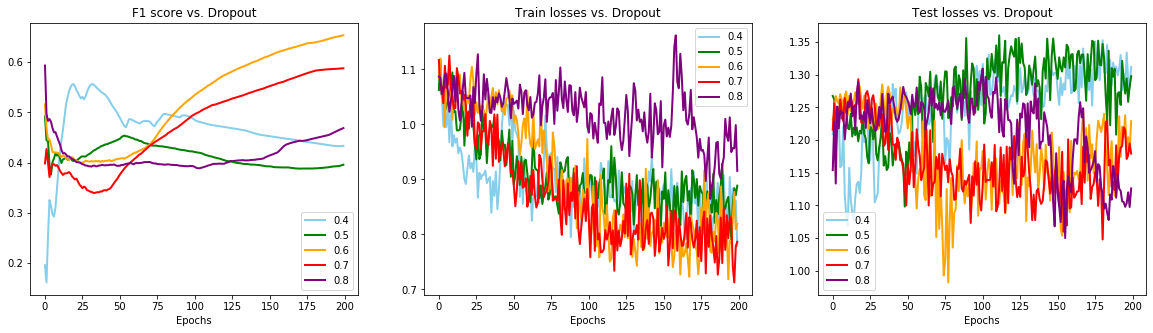

In [6]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Dropout")

In [5]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsStaticDropout_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
